In [35]:
import numpy as np
import pandas as pd
import plotly.express as px
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# mnist dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

from dataset_tools import OwnDataset, make_train_test_val_split
from plotting import (
    plot_split_stratification,
    show_img, 
    loss_plots, 
    plot_random_images, 
    plot_image_comparison, 
    plot_latent_train, 
    plot_latent)
from collections import defaultdict


cuda = torch.cuda.is_available()
print(cuda)

True


# Data

In [36]:
tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), # Randomly flips the image horizontally with a probability of 0.5.
            transforms.RandomVerticalFlip(), # Randomly flips the image vertically with a probability of 0.5.
            transforms.RandomRotation(89), # Rotates the image by a random angle within a specified range (in this case, -89 to 89 degrees).
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # Randomly changes the brightness, etc, of the image. The values (0.1) specify the maximum change.
            transforms.ToTensor(), # Converts the image to a PyTorch tensor and scales the pixel values to the range [0, 1].
])

# dataset = OwnDataset(transform=tf)
dataset = OwnDataset(transform=tf, path=r"C:\Users\Otto\Desktop\Fagprojekt_data\labelled_data")

batch_size = 96
train_subset, test_subset, val_subset = make_train_test_val_split(dataset)


train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, pin_memory=cuda, drop_last=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=True, pin_memory=cuda, drop_last=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, pin_memory=cuda, drop_last=True)

print(len(dataset), len(train_loader), len(test_loader), len(val_loader))


488396 3255 1017 814


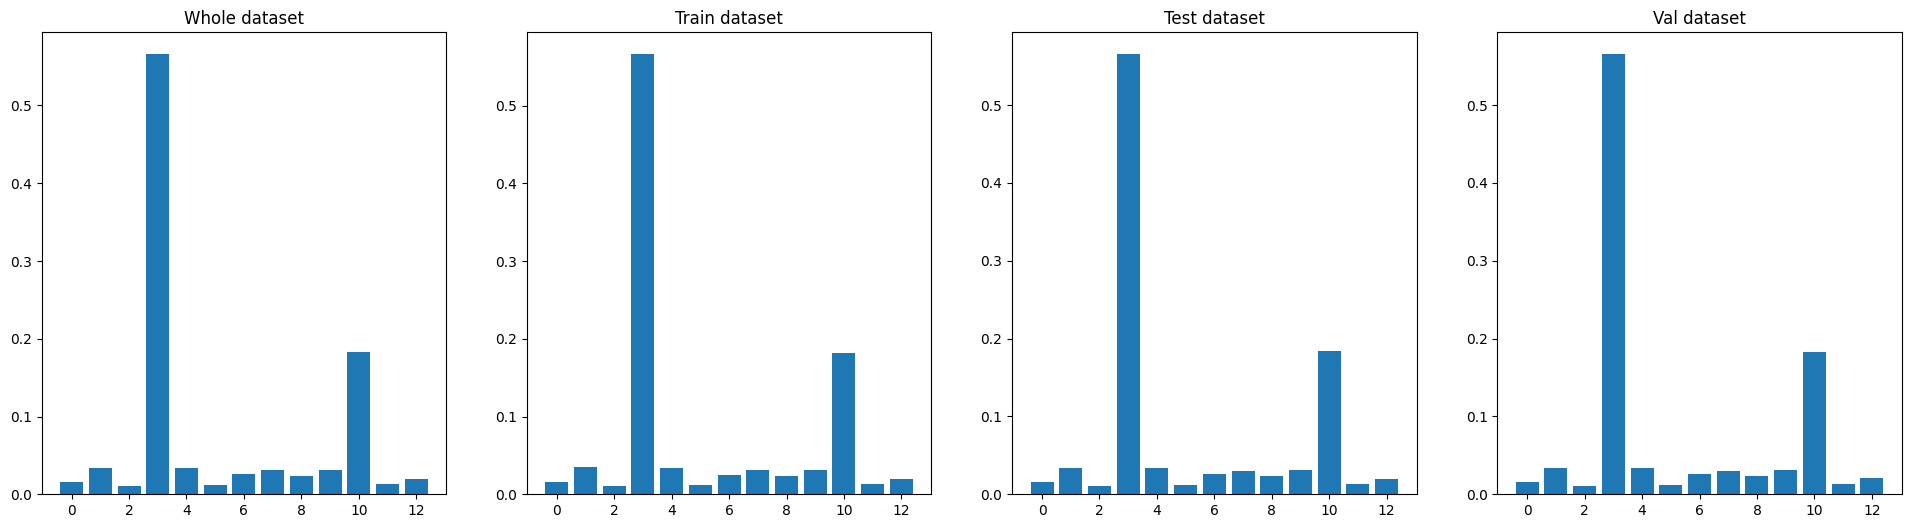

In [37]:
plot_split_stratification(dataset, train_subset, test_subset, val_subset)

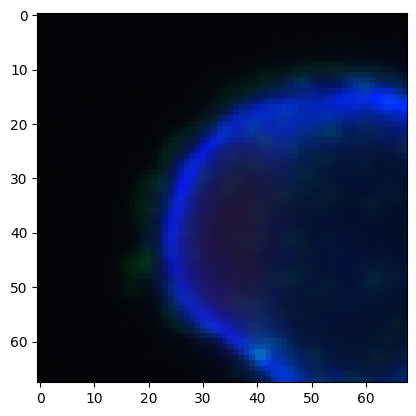

In [38]:
# get a sample image from the dataset
sample = dataset[612][0]

# show the image
show_img(sample.view(3,68,68))


In [39]:
# test how a sample looks
x, y = next(iter(train_loader))
print(x.shape, y.shape)

torch.Size([96, 3, 68, 68]) torch.Size([96])


# VAE

In [40]:
from models import VAE_CELL_CNN
# from loss_functions import loss_function_elbo_3 as loss_function
from loss_functions import loss_function_mean as loss_function
latent_dim = 8
hidden_dim = 2*latent_dim

model = VAE_CELL_CNN(input_dim=(3,68,68), hidden_dim=hidden_dim, latent_dim=latent_dim)
print(model)

if cuda:
    model = model.cuda()

lr = 5e-4
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
# optimizer = optim.Adam(model.parameters(), lr=lr)

# number of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


VAE_CELL_CNN(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=20736, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=16, out_features=20736, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Unflatten(dim=1, unflattened_size=(256, 9, 9))
    (5): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): LeakyReLU(ne

In [41]:
# test forward pass
x, y = next(iter(train_loader))
print(f"x.shape: {x.shape}")

if cuda:
    x = x.cuda()

output = model(x)
x_hat = output["x_hat"]
print(f"x_hat.shape: {x_hat.shape}")

assert x_hat.shape == x.shape

x.shape: torch.Size([96, 3, 68, 68])
x_hat.shape: torch.Size([96, 3, 68, 68])


In [42]:
# define dirs for the saving of model / data
MODEL_NAME = f"{model.__class__.__name__}_latent{model.latent_dim}_mean_"
MODEL_DIR = "trained_models/"
TRAIN_DATA_DIR = "train_data/"

print(MODEL_NAME)


VAE_CELL_CNN_latent8_mean_


## Training

In [43]:
val = True

num_epochs = 50
train_loss = []
train_mse_loss = []
train_kld_loss = []
val_loss = []
val_mse_loss = []
val_kld_loss = []

val_train_loss = []
val_train_mse_loss = []
val_train_kld_loss = []


best_loss = np.inf

for epoch in range(num_epochs):
    batch_loss = []
    mse_batch_loss = []
    kld_batch_loss = []
    model.train()

    for x, y in train_loader:
        if cuda:
            x = x.cuda()

        optimizer.zero_grad()
        output = model(x)
        x_hat, mu, sigma = output["x_hat"], output["mu"], output["sigma"]
        loss_fn = loss_function(x, x_hat, mu, sigma)
        mse_loss = loss_fn["MSE"]
        kld_loss = loss_fn["KLD"]
        loss = loss_fn["loss"]

        loss.backward()
        # clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)


        optimizer.step()

        batch_loss.append(loss.item())
        mse_batch_loss.append(mse_loss.item())
        kld_batch_loss.append(kld_loss.item())
        

    train_loss.append(np.mean(batch_loss))
    train_mse_loss.append(np.mean(mse_batch_loss))
    train_kld_loss.append(np.mean(kld_batch_loss))

    if val:
        model.eval()
        batch_loss = []
        mse_batch_loss = []
        kld_batch_loss = []

        with torch.no_grad():
            for x, y in val_loader:
                if cuda:
                    x = x.cuda()

                output_val = model(x)
                x_hat, mu, sigma = output_val["x_hat"], output_val["mu"], output_val["sigma"]
                loss_fn = loss_function(x, x_hat, mu, sigma)
                mse_loss = loss_fn["MSE"]
                kld_loss = loss_fn["KLD"]
                loss = loss_fn["loss"]

                batch_loss.append(loss.item())
                mse_batch_loss.append(mse_loss.item())
                kld_batch_loss.append(kld_loss.item())

            val_loss.append(np.mean(batch_loss))
            val_mse_loss.append(np.mean(mse_batch_loss))
            val_kld_loss.append(np.mean(kld_batch_loss))

            if val_loss[-1] < best_loss:
                best_loss = val_loss[-1]
                # torch.save(model.state_dict(), MODEL_DIR + MODEL_NAME + "best_model.pth")
        
        # try and loop over the enrtire train loader again to see if the model is overfitting
        # batch_val_train_loss = []
        # batch_val_train_mse_loss = []
        # batch_val_train_kld_loss = []
        # with torch.no_grad():
        #     for x, y in train_loader:
        #         if cuda:
        #             x = x.cuda()

        #         output_val_train = model(x)
        #         x_hat, mu, sigma = output_val_train["x_hat"], output_val_train["mu"], output_val_train["sigma"]
        #         loss_fn = loss_function(x, x_hat, mu, sigma)
        #         mse_loss = loss_fn["MSE"]
        #         kld_loss = loss_fn["KLD"]
        #         loss = loss_fn["loss"]

        #         batch_val_train_loss.append(loss.item())
        #         batch_val_train_mse_loss.append(mse_loss.item())
        #         batch_val_train_kld_loss.append(kld_loss.item())

        #     val_train_loss.append(np.mean(batch_val_train_loss))
        #     val_train_mse_loss.append(np.mean(batch_val_train_mse_loss))
        #     val_train_kld_loss.append(np.mean(batch_val_train_kld_loss))



    # print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}")
    # print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}, mse: {train_mse_loss[-1]}, kld: {train_kld_loss[-1]}")
    print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}, mse_loss: {train_mse_loss[-1]}, kld_loss: {train_kld_loss[-1]}, val_loss: {val_loss[-1]}, val_mse_loss: {val_mse_loss[-1]}, val_kld_loss: {val_kld_loss[-1]}")
    # print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}, mse_loss: {train_mse_loss[-1]}, kld_loss: {train_kld_loss[-1]}, val_loss: {val_loss[-1]}, val_mse_loss: {val_mse_loss[-1]}, val_kld_loss: {val_kld_loss[-1]}, val_train_loss: {val_train_loss[-1]}, val_train_mse_loss: {val_train_mse_loss[-1]}, val_train_kld_loss: {val_train_kld_loss[-1]}")
    
    # plot_latent(output)



Epoch 1/50, loss: 155.80099210958878, mse_loss: 140.1211669312461, kld_loss: 15.679825423184651, val_loss: 128.3131415439765, val_mse_loss: 111.84818097238751, val_kld_loss: 16.464960816451313
Epoch 2/50, loss: 125.99149136638495, mse_loss: 109.95868247130316, kld_loss: 16.032809077027025, val_loss: 124.24559851419134, val_mse_loss: 108.16326378487251, val_kld_loss: 16.082334775010843
Epoch 3/50, loss: 123.21007453461397, mse_loss: 107.21432962959629, kld_loss: 15.99574496273621, val_loss: 122.31235418858634, val_mse_loss: 106.12067581101776, val_kld_loss: 16.191678403343555
Epoch 4/50, loss: 121.73438982985536, mse_loss: 105.70351185132098, kld_loss: 16.030878024240426, val_loss: 121.61832504834824, val_mse_loss: 105.74224971611903, val_kld_loss: 15.876075682534633
Epoch 5/50, loss: 120.75056851294732, mse_loss: 104.65994508804813, kld_loss: 16.090623462108606, val_loss: 120.74345501986417, val_mse_loss: 104.36829646155056, val_kld_loss: 16.375158564171567
Epoch 6/50, loss: 120.038178

# Evaluate model on test set

In [44]:
# we evaluate model on test set
test_loss = []
test_mse_loss = []
test_kld_loss = []
model.eval()

for x, y in test_loader:
    if cuda:
        x = x.cuda()

    output_test = model(x)
    x_hat, mu, sigma = output_test["x_hat"], output_test["mu"], output_test["sigma"]
    loss_fn = loss_function(x, x_hat, mu, sigma)
    mse_loss = loss_fn["MSE"]
    kld_loss = loss_fn["KLD"]
    loss = loss_fn["loss"]

    test_loss.append(loss.item())
    test_mse_loss.append(mse_loss.item())
    test_kld_loss.append(kld_loss.item())

print(f"Test loss: {np.mean(test_loss)}, Test mse loss: {np.mean(test_mse_loss)}, Test kld loss: {np.mean(test_kld_loss)}")

Test loss: 117.09956910500016, Test mse loss: 100.51838966152074, Test kld loss: 16.58117915653315


## Plots

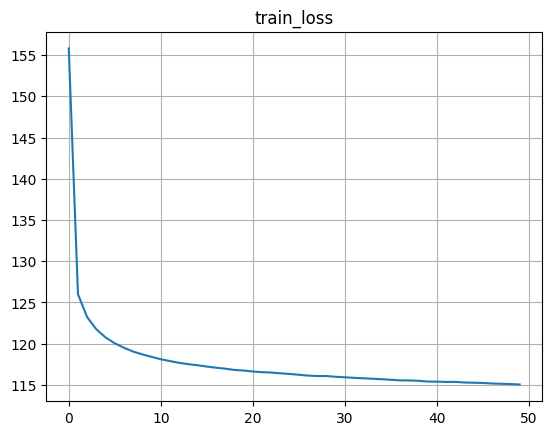

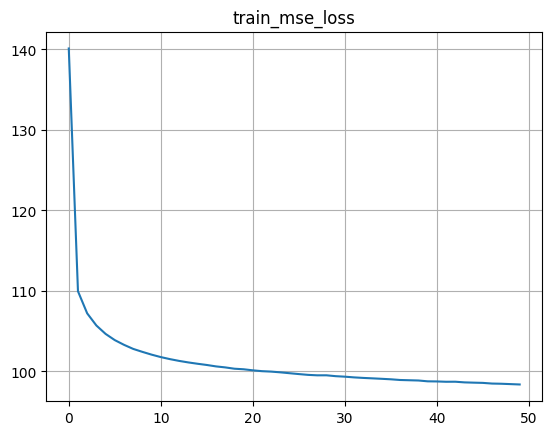

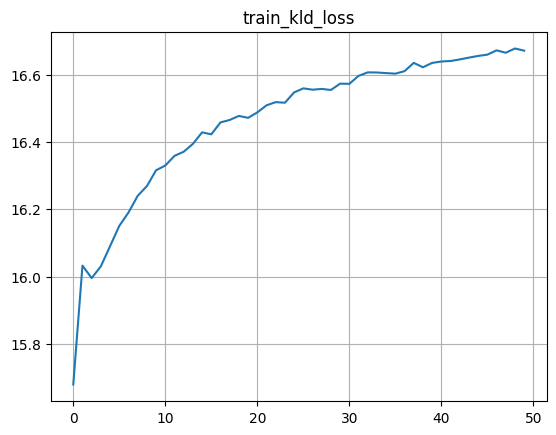

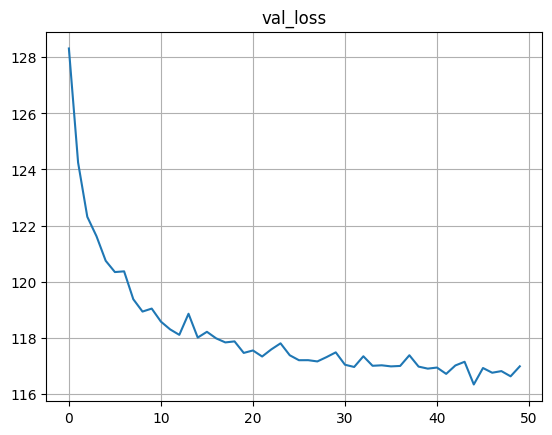

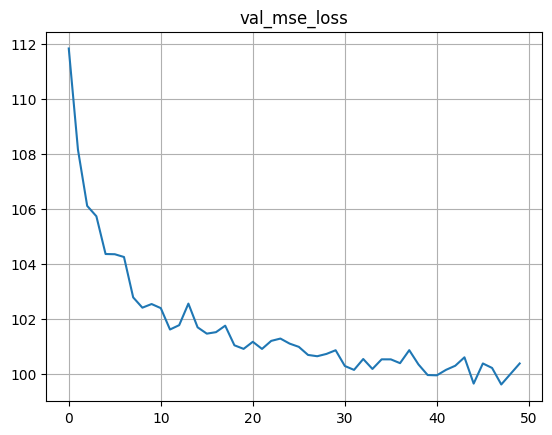

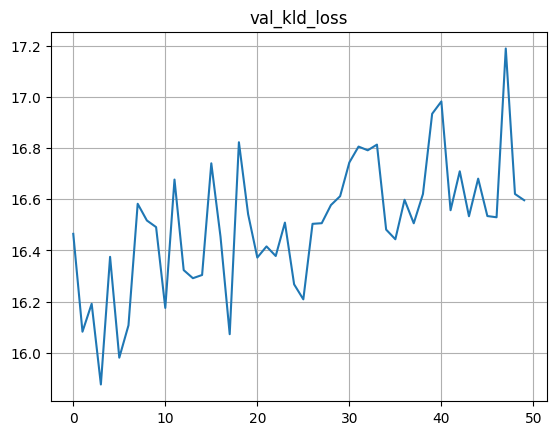

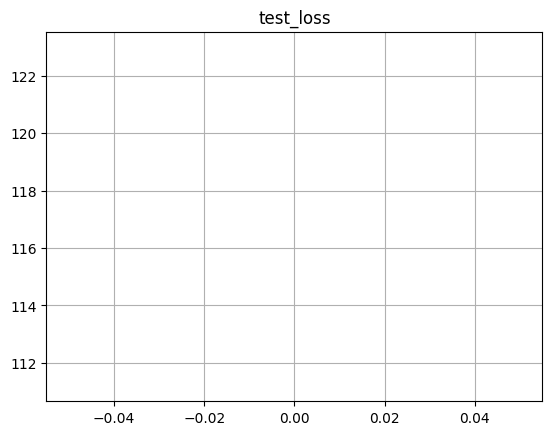

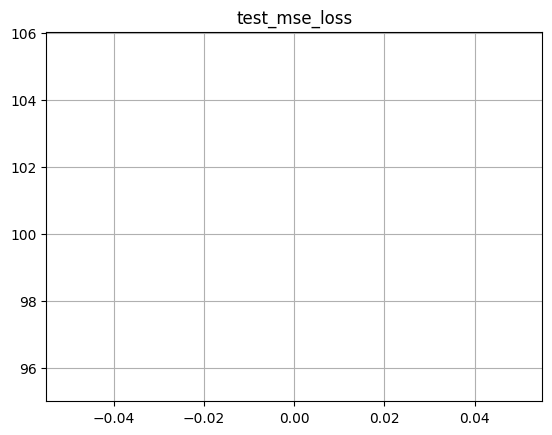

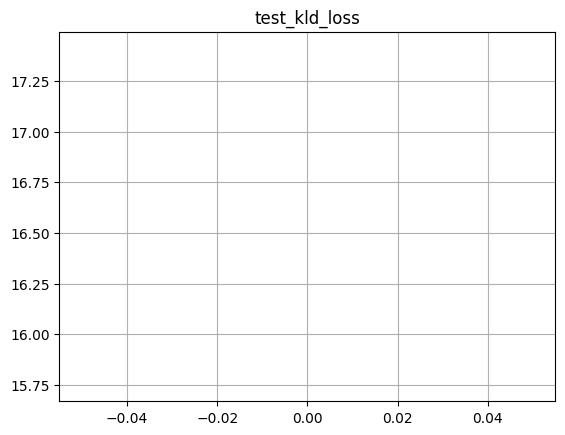

In [45]:
# make a dictionary with the losses as keys and the values as lists
#loss_data = {}
#loss_data["train_loss"] = train_loss
#loss_data["train_mse_loss"] = train_mse_loss
#loss_data["train_kld_loss"] = train_kld_loss
#loss_data["val_loss"] = val_loss
#loss_data["val_mse_loss"] = val_mse_loss
# loss_data["val_kld_loss"] = val_kld_loss
# loss_data["test_loss"] = np.mean(test_loss)
# loss_data["test_mse_loss"] = np.mean(test_mse_loss)
# loss_data["test_kld_loss"] = np.mean(test_kld_loss)

# loss_plots(loss_data, invidual_plots=True, title="")

# df = pd.DataFrame(loss_data)
# try:
#     old_df = pd.read_csv(TRAIN_DATA_DIR + MODEL_NAME + "loss_data.csv")
#     df = pd.concat([old_df, df])
# except:
#     pass
# df.to_csv(TRAIN_DATA_DIR + MODEL_NAME + "loss_data.csv", index=False)


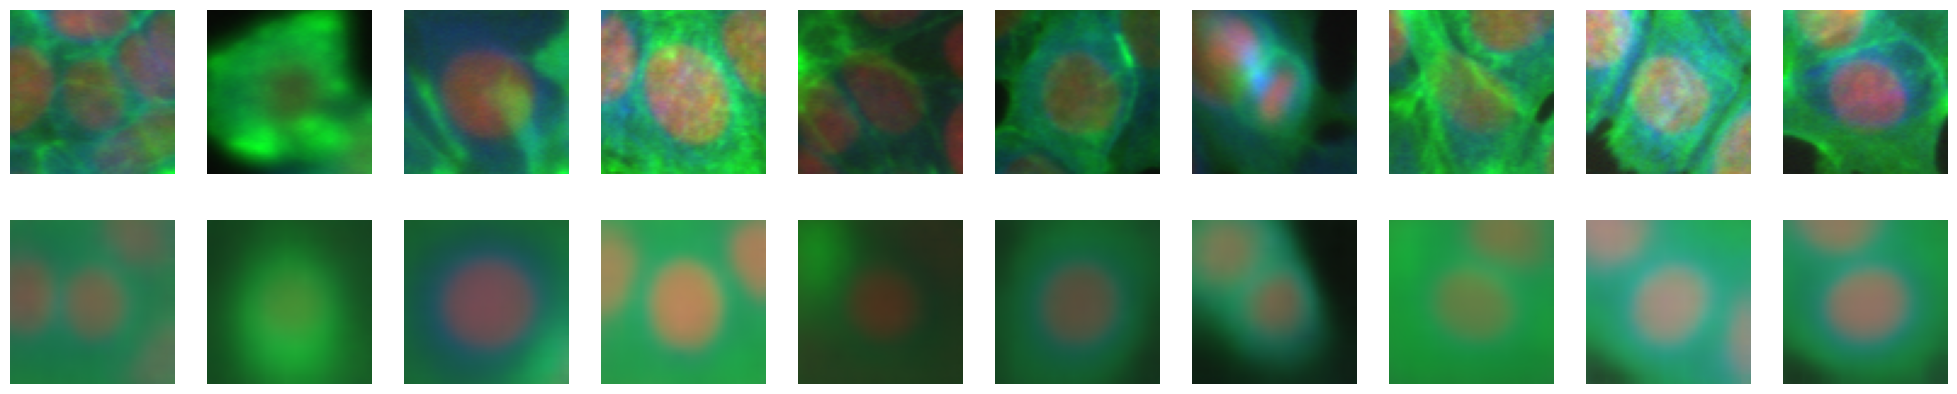

In [46]:
# test the model
plot_image_comparison(model, test_loader, cuda, img_shape=(3,68,68))


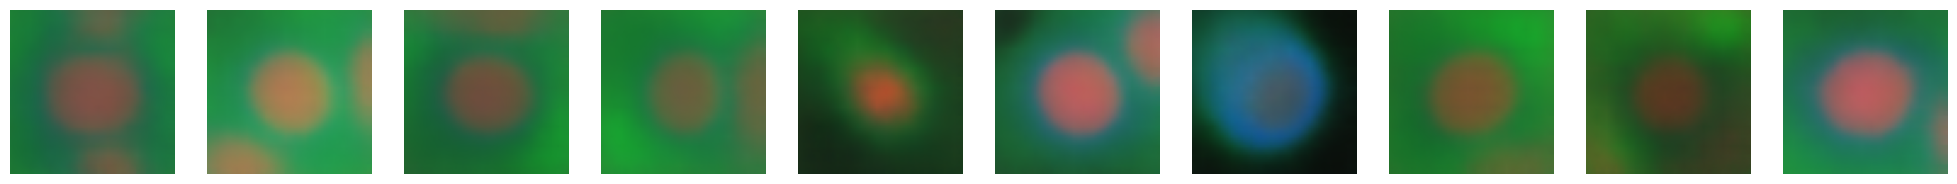

In [47]:
# plot random images generated from the model
plot_random_images(model, n=10, img_shape=(3,68,68), cuda=cuda)

In [48]:
# calculate mse loss between original and generated images
mse_losses = []

model.eval()
if cuda:
    model = model.cuda()
with torch.no_grad():
    for x, y in test_loader:
        if cuda:
            x = x.cuda()

        output = model(x)
        x_hat = output["x_hat"]
        mse_loss = F.mse_loss(x_hat, x, reduction="none")
        mse_losses.append(mse_loss.cpu().numpy())

mse_losses = np.concatenate(mse_losses, axis=0)
print(torch.mean(mse_loss).item(), torch.std(mse_loss).item())


0.007112585939466953 0.018716590479016304


In [49]:
from inference import Inference

inference = Inference(model, test_loader)

In [50]:
samples = inference.samples

In [51]:
# show_img(samples['1'][3])